# 주택가격 예측: 회귀문제

1. 회귀(regression)는 개별적인 레이블(분류) 대신 연속적인 값을 예측하는 것
2. 예시
    + 기상데이터가 주어졌을 때 내일 기온 예측하기
    + 소프트웨어 명세가 주어졌을 때 소프트웨어 프로젝트가 완료될 시간을 예측하는 것

## <span style="color:orange"> 1. </span> <span style="color:black">보스턴 주택 가격 데이터셋</span>
+ 1970년대 보스턴 외각 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간값을 예측하는 것.
+ 데이터 포인트가 506개로 적음. 404개는 훈련 샘플, 102개는 테스트 샘플로 구분됨.
+ 입력 데이터에 있는 각 특성(feature)은 스케일이 서로 다름.
+ 어떤 값은 0과 1 사이의 비율, 어떤 것은 1과 100 사이의 값을 가짐

In [1]:
# 보스턴 주택 데이터셋 로드하기
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# 데이터 살펴보기
print(train_data.shape)
print(test_data.shape)

Using TensorFlow backend.


(404, 13)
(102, 13)


## <span style="color:orange"> 2. </span> <span style="color:black"> 데이터 준비</span>

+ 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 됨.
+ 이런 데이터를 다루는 대표적인 방법은 특성별로 정규화(noramlize)를 하는 것임.
+ 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해 특성의 평균을 빼고 표준편차로 나눔.
+ 특성의 중앙이 0 근처에 맞춰지고 표준편차가 1이 됨. 넘파이를 사용하면 편함.
+ 표준화 과정에서 훈련용 데이터 셋을 이용하여 계산된 평균과 표준편차를 사용해야 함. **머신러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안 됨.**

In [2]:
# 데이터 정규화하기

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data -= std

test_data -= mean # 훈련용 데이터의 평균과 표준편차로 표준화를 실시한 것을 주목하라.
test_data /= std

## <span style="color:orange"> 3. </span><span style="color:black"> 모델 구성</span>

+ 샘플 개수(N=506)가 적기 때문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 데이터를 구성하여 사용
+ 일반적으로 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어남.
+ 이런 경우 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법임
+ 회귀 문제에는 일반적으로 하나의 유닛을 갖고 있고 활성화 함수를 사용하지 않음(일반적으로 선형층이라 부름)
+ 손실함수(loss function)로는 평균제곱오차를 일반적으로 사용함. 평균 절대 오차(mean absolute error, mae)는 예측과 타깃 사이의 거리의 절댓을 의미함.

In [8]:
# 모델 정의하기

from keras import models
from keras import layers

def build_model(): # 동일한 모델을 여러번 생성할 것이므로 함수를 만들어 사용함.
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu',
                          input_shape = (train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1)) # 회귀 모델에서는 일반적으로 하나의 유닛을 갖고 있고, 활성화 함수가 없음(출력값을 제한하기 때문).
    # 손실함수: mse(평균제곱오차, mean square error). 훈련 모니터링: mae(평균절대오차, mean absolute error)
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae']) 
    return model

## <span style="color:orange"> 4. </span><span style="color:black"> K-겹 검증을 사용한 훈련 검증</span>

+ 데이터 포인트가 많지 않기 때문에 검증 세트가 작을 수밖에 없음(N=102). 이 경우 검증 세트의 분할에 따라 검증 점수의 분산이 높음. 이렇게 되면 신뢰 있는 모델 평가를 할 수 없음.
+ 이런 상황에서 **K-겹 교차 검증(K-fold cross-validation)** 을 사용할 수 있음.
+ 이 방법은 데이터를 K 개의 분할(fold)로 나누고, K개의 모델을 만들어 각각 K-1개의 분할에서 훈련하고 나머지 한 개의 분할에서 평가함. 일반적으로 4겹 혹은 5겹 교차검증을 사용함.
+ 모델의 검증 점수는 K개의 검증 점수 평균이 됨.

*교차 검증 예시*

<a href="https://ibb.co/sRvmJjt"><img src="https://i.ibb.co/wgN0ryY/1.jpg" alt="1" border="0" align = 'left'></a>

In [10]:
# K-겹 검증하기
import numpy as np

k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i+1) * num_val_samples:]], 
    axis = 0)

    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i+1) * num_val_samples:]], 
    axis = 0)
    
    model = build_model() # 케라스 모델 구성(컴파일 포함)
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size = 1, verbose = 0)  #verbose = 0으로 설정하면 훈련 과정이 출력되지 않음.
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)  

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [15]:
# mae 결과
print(all_scores)

# mae 평균
print(np.mean(all_scores))

[2.3287519676850574, 2.7868107002560456, 2.691815532080018, 2.48827060024337]
2.5739122000661228


In [16]:
# 훈련 횟수를 500 에포크로 늘려보기
# 각 폴드에서 검증 점수를 로그에 저장하기

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i+1) * num_val_samples:]], 
    axis = 0)

    partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i+1) * num_val_samples:]], 
    axis = 0)
    
    model = build_model() # 케라스 모델 구성(컴파일 포함)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose = 0)  #verbose = 0으로 설정하면 훈련 과정이 출력되지 않음.
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

    
# K겹 검증 점수 평균을 기록하기
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


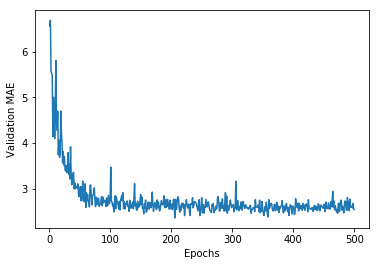

In [18]:
# 검증 점수 그래프

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

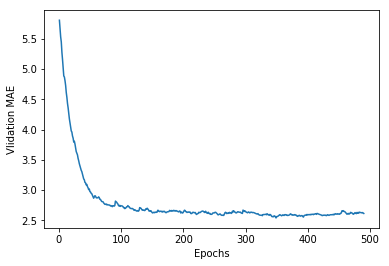

In [19]:
'''
위의 그림에서 훈련 초기에는 mae의 범위가 크고 변동이 심합니다. 
그래서 이 데이터 포인트를 제외하고 그림을 만들 것임..
부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체.
*지수 평균 이동: 시계열 데이터를 부드럽게 만드는 기법 중 하나.
'''

# 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기

def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Vlidation MAE')
plt.show()

In [ ]:
# 최종 모델 훈련하기
model = build_model()
model.fit(train_data, train_target,
         epochs = 80, batch_size = 16, verbose = 0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

## <span style="color:orange"> 5. </span><span style="color:black"> 정리</span>

+ 회귀는 분류에서 사용한 것과 다른 손실함수(mse)를 사용함.
+ 회귀에서 사용되는 평가 지표는 분류 문제외는 다름. 일반적인 회귀 지표는 평균 절대 오차(mae)임.
+ 입력 데이터의 특성이 서로 다른 범위를 가지면 전처리 단계에서 각 특성의 스케일을 개별적으로 조정해야 함: 표준화.
+ 가용한 데이터가 적다면 K-겹 ㅂ검증을 사용하는 것이 신뢰할 수 있는 모델 평가 방법임.
+ 가용한 훈련 데이터가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋음(일반적으로 1개 또는 2개).